### References
- https://keras.io/examples/vision/autoencoder/


In [259]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from skimage import metrics
from keras import layers
from keras.datasets import mnist
from keras.models import Model

def preprocess(array):
    """Normalizes the supplied array and reshapes it."""
    array = array.astype("float32") / 255.0
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def noise(array, lam):
    """Use poisson noise lambda"""
    array = np.random.poisson(array * lam) / lam
    return array



def display(array1, array2, array3=[]):
    """Displays ten random images from each array."""
    n = 10
    indices = np.random.randint(len(array1), size=n)
    images1 = array1[indices, :]
    images2 = array2[indices, :]
    images3 =  [None] * n

    plt.figure(figsize=(20, 4))
    if len(array3) > 0:
        images3 = array3[indices, :]
        plt.figure(figsize=(20, 6))

    for i, (image1, image2, image3) in enumerate(zip(images1, images2, images3)):
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(image1.reshape(64, 64))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        img2arg = 2
        if image3 is not None:
            img2arg = 3
        ax = plt.subplot(img2arg, n, i + 1 + n)
        plt.imshow(image2.reshape(64, 64))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        if image3 is not None:
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(image3.reshape(64, 64))
            plt.gray()
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)

    plt.show()

def calculate_similarity(src, dst):
    # Squeeze out the third dimension if it's 1
    if src.shape[-1] == 1:
        src = np.squeeze(src, axis=-1)
    if dst.shape[-1] == 1:
        dst = np.squeeze(dst, axis=-1)
    ssim_score = metrics.structural_similarity(src, dst, data_range=src.max() - src.min())
    return ssim_score

 

### Denoising Functions

In [251]:

MAX_KERNEL_LENGTH = 31

def apply_mean_filter(src):
  dst = cv.blur(src, (MAX_KERNEL_LENGTH, MAX_KERNEL_LENGTH))
  return dst
    

def apply_gaussian_blur(src):
  dst = cv.GaussianBlur(src, (MAX_KERNEL_LENGTH, MAX_KERNEL_LENGTH), 0)
  return dst
  

def apply_median_filter(src):
  # Convert the image to grayscale and uint8 if necessary
  src = 255 * src # Now scale by 255
  src = src.astype(np.uint8)

  dst = cv.medianBlur(src, MAX_KERNEL_LENGTH)

  # convert back to float32
  dst = dst.astype(np.float32) / 255.0


  return dst


def apply_bilateral_filter(src):

  src = 255 * src # Now scale by 255
  src = src.astype(np.uint8)

  dst = cv.bilateralFilter(src.astype(np.uint8), MAX_KERNEL_LENGTH, MAX_KERNEL_LENGTH * 2, MAX_KERNEL_LENGTH / 2)

  # convert back to float32
  dst = dst.astype(np.float32) / 255.0
 
  
  return dst


### Helper functions for calculating average SSIM scores

In [230]:
def get_average_score(test_data, apply_fn):
    score = 0
    images = []
    for i in range(len(test_data)):
      img = apply_fn(test_data[i])
      images.append(img)
      score += calculate_similarity(test_data[i], img)

    return (score / len(test_data), np.array(images))



Importing images...
Finished importing train images
Finished importing test images


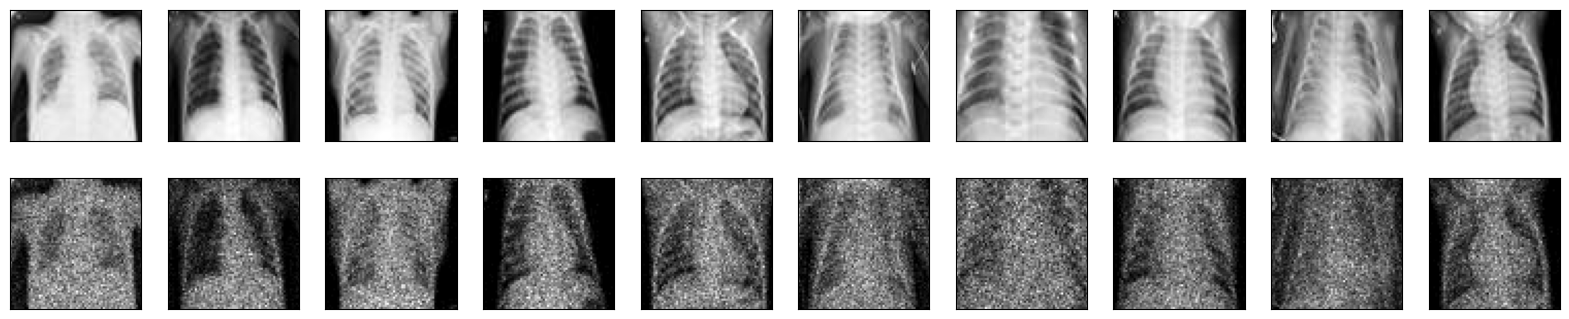

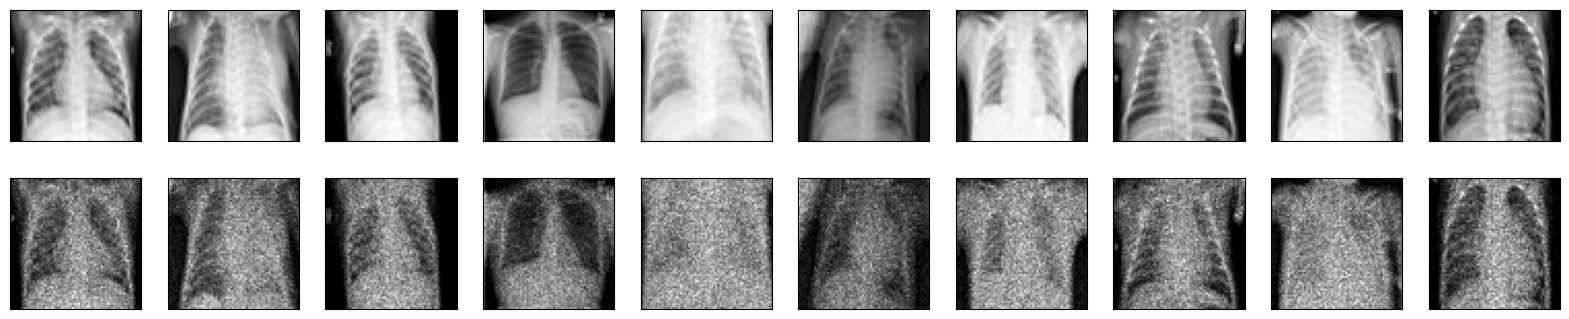

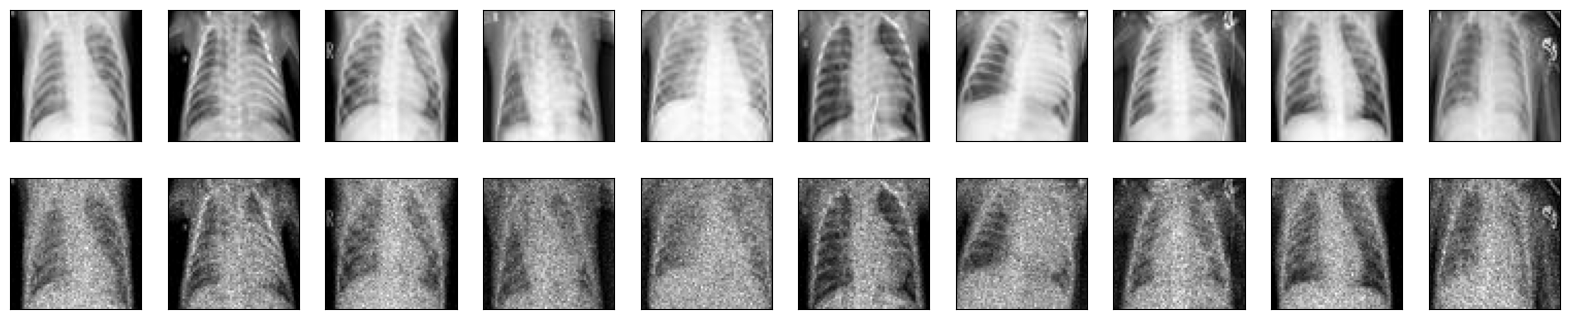

In [284]:
import os
import numpy as np
from keras.datasets import mnist
from keras.preprocessing import image




print('Importing images...')
train_data = []
train_image_names = os.listdir('./train')
for i in range(len(train_image_names)):
    img = image.load_img(
        './train/' + train_image_names[i]
        , target_size=(64,64), color_mode= 'grayscale')
    img = image.img_to_array(img)
    img = img / 255
    train_data.append(img)

train_data = np.array(train_data)
print("Finished importing train images")

# import images from ./test
test_data = []
test_image_names = os.listdir('./test')

# Max 10 images
for i in range(len(test_image_names)):
    img = image.load_img(
        './test/' + test_image_names[i]
        , target_size=(64,64), color_mode= 'grayscale')
    img = image.img_to_array(img)
    img = img / 255
    test_data.append(img)
    

test_data = np.array(test_data)
print("Finished importing test images")



# Normalize and reshape the data

# Create a copy of the data with added noise
noisy_train_data_25 = noise(train_data, 25)
noisy_test_data_25 = noise(test_data, 25)

noisy_train_data_50 = noise(train_data, 50)
noisy_test_data_50 = noise(test_data, 50)

noisy_train_data_75 = noise(train_data, 75)
noisy_test_data_75 = noise(test_data, 75)

# # Display the train data and a version of it with added noise

display(train_data, noisy_train_data_25)
display(train_data, noisy_train_data_50)
display(train_data, noisy_train_data_75)



In [4]:

input = layers.Input(shape=(64, 64, 1))

# Encoder
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(input)
x = layers.MaxPooling2D((2, 2), padding="same")(x)
x = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(x)
x = layers.MaxPooling2D((2, 2), padding="same")(x)

# Decoder
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2DTranspose(64, (3, 3), strides=2, activation="relu", padding="same")(x)
x = layers.Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

# Autoencoder
autoencoder = Model(input, x)
autoencoder.compile(optimizer="adam", loss="binary_crossentropy")
autoencoder.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 64, 64, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 32, 32, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_transpose (Conv2DTr  (None, 32, 32, 64)        36928 

In [15]:
autoencoder.fit(
    x=train_data,
    y=train_data,
    shuffle=True,
		epochs=10,
		batch_size=10,
    validation_data=(test_data, test_data),
)

Epoch 1/10
185/185 [==============================] - 9s 50ms/step - loss: 0.5688 - val_loss: 0.5698
Epoch 2/10
185/185 [==============================] - 9s 47ms/step - loss: 0.5687 - val_loss: 0.5698
Epoch 3/10
185/185 [==============================] - 8s 44ms/step - loss: 0.5687 - val_loss: 0.5697
Epoch 4/10
185/185 [==============================] - 8s 46ms/step - loss: 0.5687 - val_loss: 0.5696
Epoch 5/10
185/185 [==============================] - 9s 49ms/step - loss: 0.5686 - val_loss: 0.5696
Epoch 6/10
185/185 [==============================] - 9s 47ms/step - loss: 0.5686 - val_loss: 0.5696
Epoch 7/10
185/185 [==============================] - 9s 50ms/step - loss: 0.5686 - val_loss: 0.5695
Epoch 8/10
185/185 [==============================] - 9s 50ms/step - loss: 0.5685 - val_loss: 0.5697
Epoch 9/10
185/185 [==============================] - 10s 53ms/step - loss: 0.5685 - val_loss: 0.5695
Epoch 10/10
185/185 [==============================] - 10s 52ms/step - loss: 0.5685 - val_

15/15 [==============================] - 1s 34ms/step


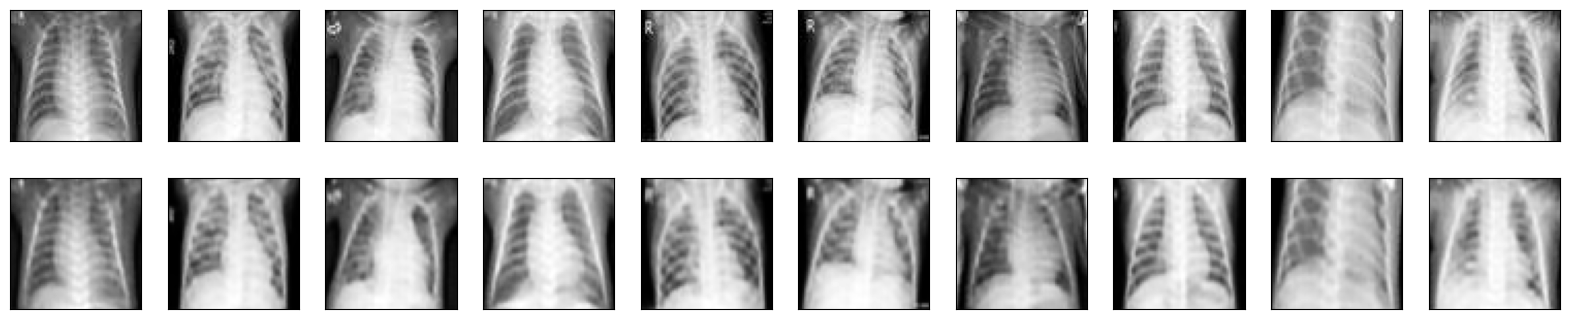

In [16]:
predictions = autoencoder.predict(test_data)
display(test_data, predictions)

In [82]:
# Lambda 25
autoencoder.fit(
    x=noisy_train_data_25,
    y=train_data,
    epochs=100,
    batch_size=10,
    shuffle=True,
    validation_data=(noisy_test_data_25, test_data),
)

Epoch 1/100
185/185 [==============================] - 9s 47ms/step - loss: 0.5714 - val_loss: 0.5724
Epoch 2/100
185/185 [==============================] - 8s 45ms/step - loss: 0.5713 - val_loss: 0.5724
Epoch 3/100
185/185 [==============================] - 8s 44ms/step - loss: 0.5713 - val_loss: 0.5725
Epoch 4/100
185/185 [==============================] - 8s 44ms/step - loss: 0.5713 - val_loss: 0.5723
Epoch 5/100
185/185 [==============================] - 8s 45ms/step - loss: 0.5712 - val_loss: 0.5723
Epoch 6/100
185/185 [==============================] - 8s 44ms/step - loss: 0.5712 - val_loss: 0.5723
Epoch 7/100
185/185 [==============================] - 8s 44ms/step - loss: 0.5713 - val_loss: 0.5723
Epoch 8/100
185/185 [==============================] - 8s 45ms/step - loss: 0.5712 - val_loss: 0.5722
Epoch 9/100
185/185 [==============================] - 8s 46ms/step - loss: 0.5712 - val_loss: 0.5723
Epoch 10/100
185/185 [==============================] - 8s 45ms/step - loss: 0.571

15/15 [==============================] - 1s 34ms/step


<Figure size 2000x400 with 0 Axes>

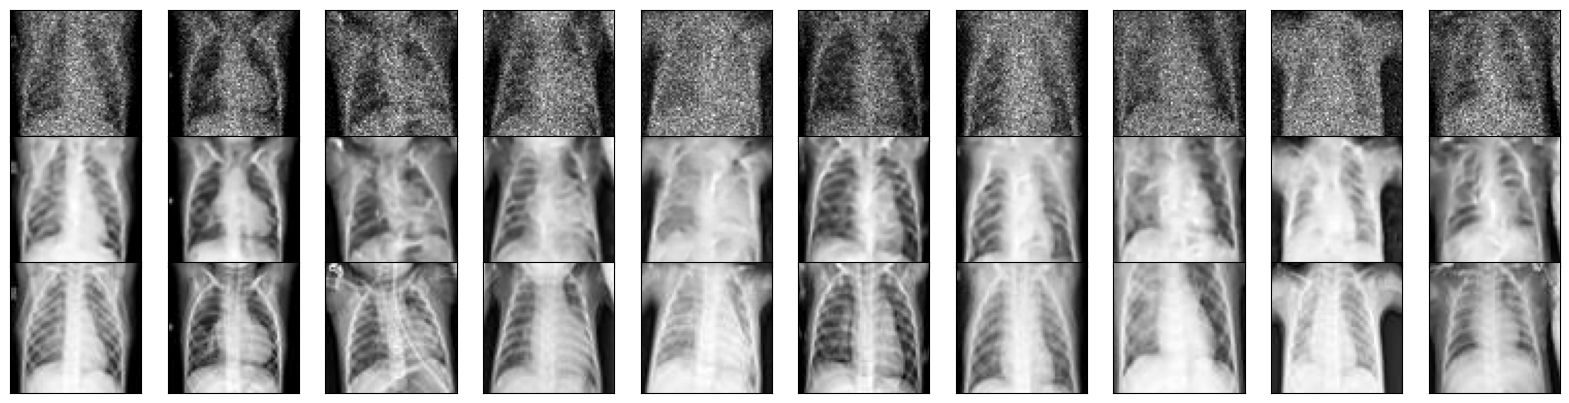

Lambda 25
Average SSIM:  0.8039937339344139
Average SSIM with mean filter:  0.08580572666296421
Average SSIM with gaussian blur:  0.1733063529576175
Average SSIM with median filter:  0.1371339259052133
Average SSIM with bilateral filter:  0.5543819543163463


In [262]:
predictions = autoencoder.predict(noisy_test_data_25)

scores_25 = []
for i in range(len(predictions)):
	scores_25.append(calculate_similarity(test_data[i], predictions[i]))


res_mean_25 = get_average_score(noisy_test_data_25, apply_mean_filter)
res_gauss_25 = get_average_score(noisy_test_data_25, apply_gaussian_blur)
res_median_25 = get_average_score(noisy_test_data_25, apply_median_filter)
res_bi_25 = get_average_score(noisy_test_data_25, apply_bilateral_filter)

display(noisy_test_data_25, predictions, test_data)

print("Lambda 25")
print("Average SSIM: ", sum(scores_25) / len(scores_25))
print("Average SSIM with mean filter: ", res_mean_25[0])
print("Average SSIM with gaussian blur: ", res_gauss_25[0])
print("Average SSIM with median filter: ", res_median_25[0])
print("Average SSIM with bilateral filter: ", res_bi_25[0])



### Lambda 50

In [280]:

autoencoder.fit(
    x=noisy_train_data_50,
    y=train_data,
    epochs=100,
    batch_size=10,
    shuffle=True,
    validation_data=(noisy_test_data_50, test_data),
)

Epoch 1/100
185/185 [==============================] - 10s 51ms/step - loss: 0.5695 - val_loss: 0.5708
Epoch 2/100
185/185 [==============================] - 9s 49ms/step - loss: 0.5695 - val_loss: 0.5708
Epoch 3/100
185/185 [==============================] - 9s 48ms/step - loss: 0.5695 - val_loss: 0.5708
Epoch 4/100
185/185 [==============================] - 9s 46ms/step - loss: 0.5695 - val_loss: 0.5708
Epoch 5/100
185/185 [==============================] - 9s 46ms/step - loss: 0.5695 - val_loss: 0.5708
Epoch 6/100
185/185 [==============================] - 8s 45ms/step - loss: 0.5695 - val_loss: 0.5708
Epoch 7/100
185/185 [==============================] - 8s 42ms/step - loss: 0.5695 - val_loss: 0.5708
Epoch 8/100
185/185 [==============================] - 8s 44ms/step - loss: 0.5695 - val_loss: 0.5708
Epoch 9/100
185/185 [==============================] - 8s 44ms/step - loss: 0.5695 - val_loss: 0.5708
Epoch 10/100
185/185 [==============================] - 9s 49ms/step - loss: 0.56

15/15 [==============================] - 1s 34ms/step


<Figure size 2000x400 with 0 Axes>

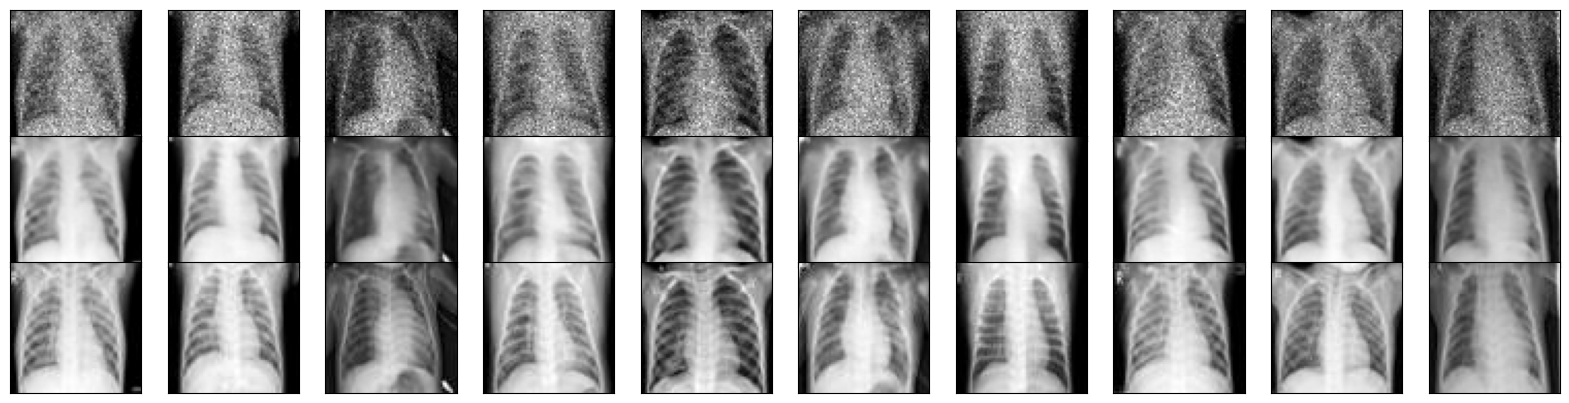

Lambda 50
Average SSIM:  0.8653333060110899
Average SSIM with mean filter:  0.10953205445284647
Average SSIM with gaussian blur:  0.22440668784168044
Average SSIM with median filter:  0.17814000917812445
Average SSIM with bilateral filter:  0.5739141395556024


In [281]:

predictions = autoencoder.predict(noisy_test_data_50)

scores_50 = []
for i in range(len(predictions)):
	scores_50.append(calculate_similarity(test_data[i], predictions[i]))


res_mean_50 = get_average_score(noisy_test_data_50, apply_mean_filter)
res_gauss_50 = get_average_score(noisy_test_data_50, apply_gaussian_blur)
res_median_50 = get_average_score(noisy_test_data_50, apply_median_filter)
res_bi_50 = get_average_score(noisy_test_data_50, apply_bilateral_filter)

display(noisy_test_data_50, predictions, test_data)

print("Lambda 50")
print("Average SSIM: ", sum(scores_50) / len(scores_50))
print("Average SSIM with mean filter: ", res_mean_50[0])
print("Average SSIM with gaussian blur: ", res_gauss_50[0])
print("Average SSIM with median filter: ", res_median_50[0])
print("Average SSIM with bilateral filter: ", res_bi_50[0])



### Lambda = 75

In [268]:

autoencoder.fit(
    x=noisy_train_data_75,
    y=train_data,
    epochs=100,
    batch_size=10,
    shuffle=True,
    validation_data=(noisy_test_data_75, test_data),
)

Epoch 1/100
185/185 [==============================] - 8s 46ms/step - loss: 0.5696 - val_loss: 0.5725
Epoch 2/100
185/185 [==============================] - 8s 45ms/step - loss: 0.5695 - val_loss: 0.5726
Epoch 3/100
185/185 [==============================] - 8s 44ms/step - loss: 0.5696 - val_loss: 0.5724
Epoch 4/100
185/185 [==============================] - 8s 45ms/step - loss: 0.5696 - val_loss: 0.5725
Epoch 5/100
185/185 [==============================] - 8s 44ms/step - loss: 0.5696 - val_loss: 0.5726
Epoch 6/100
185/185 [==============================] - 9s 46ms/step - loss: 0.5695 - val_loss: 0.5727
Epoch 7/100
185/185 [==============================] - 8s 44ms/step - loss: 0.5695 - val_loss: 0.5726
Epoch 8/100
185/185 [==============================] - 8s 45ms/step - loss: 0.5695 - val_loss: 0.5727
Epoch 9/100
185/185 [==============================] - 8s 45ms/step - loss: 0.5695 - val_loss: 0.5726
Epoch 10/100
185/185 [==============================] - 8s 45ms/step - loss: 0.569

15/15 [==============================] - 1s 34ms/step


<Figure size 2000x400 with 0 Axes>

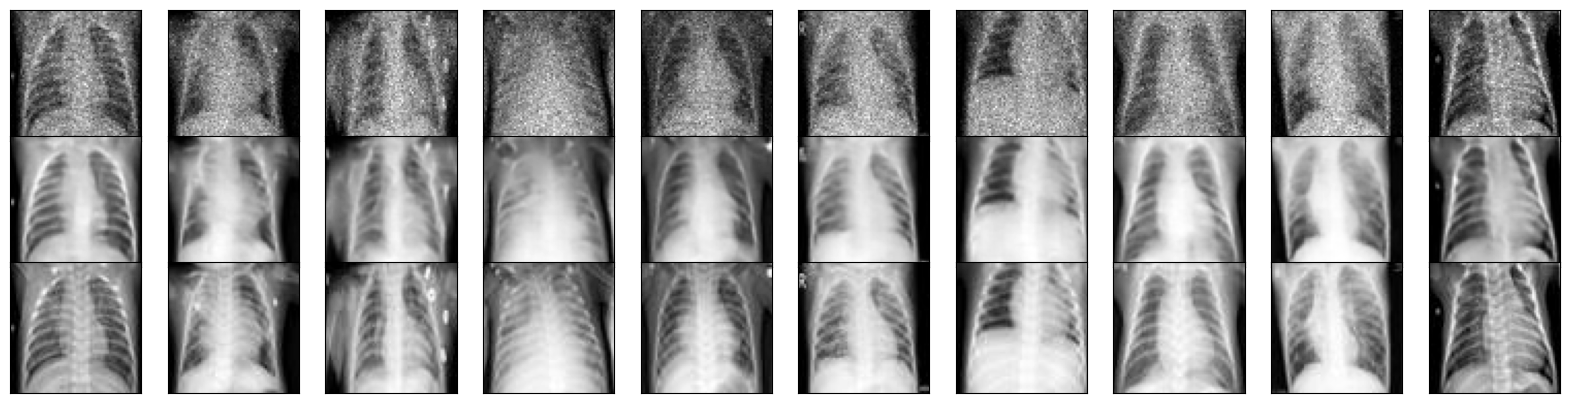

Lambda 75
Average SSIM:  0.8662490437167297
Average SSIM with mean filter:  0.12405043207868337
Average SSIM with gaussian blur:  0.2552810482604323
Average SSIM with median filter:  0.20071823195648608
Average SSIM with bilateral filter:  0.5840508513609328


In [286]:

predictions = autoencoder.predict(noisy_test_data_50)

scores_75 = []
for i in range(len(predictions)):
	scores_75.append(calculate_similarity(test_data[i], predictions[i]))


res_mean_75 = get_average_score(noisy_test_data_75, apply_mean_filter)
res_gauss_75 = get_average_score(noisy_test_data_75, apply_gaussian_blur)
res_median_75 = get_average_score(noisy_test_data_75, apply_median_filter)
res_bi_75 = get_average_score(noisy_test_data_75, apply_bilateral_filter)

display(noisy_test_data_75, predictions, test_data)

print("Lambda 75")
print("Average SSIM: ", sum(scores_75) / len(scores_75))
print("Average SSIM with mean filter: ", res_mean_75[0])
print("Average SSIM with gaussian blur: ", res_gauss_75[0])
print("Average SSIM with median filter: ", res_median_75[0])
print("Average SSIM with bilateral filter: ", res_bi_75[0])



In [287]:
from beautifultable import BeautifulTable

table = BeautifulTable()
table.set_style(BeautifulTable.STYLE_MARKDOWN)
table.column_headers = ["","Lambda = 25", "Lambda = 50", "Lambda = 75"]

table.append_row([
	"Median Filter",
	res_median_25[0],
	res_median_50[0],
	res_median_75[0],
])

table.append_row([
	"Mean Filter",
	res_mean_25[0],
	res_mean_50[0],
	res_mean_75[0],
])

table.append_row([
	"Gaussian Blur",
	res_gauss_25[0],
	res_gauss_50[0],
	res_gauss_75[0],
])

table.append_row([
	"Bilateral Filter",
	res_bi_25[0],
	res_bi_50[0],
	res_bi_75[0],
])

table.append_row([
	"Autoencoder",
	sum(scores_25) / len(scores_25),
	sum(scores_50) / len(scores_50),
	sum(scores_75) / len(scores_75),
])



print(table)


|                  | Lambda = 25 | Lambda = 50 | Lambda = 75 |
|------------------|-------------|-------------|-------------|
|  Median Filter   |    0.137    |    0.178    |    0.201    |
|   Mean Filter    |    0.086    |    0.11     |    0.124    |
|  Gaussian Blur   |    0.173    |    0.224    |    0.255    |
| Bilateral Filter |    0.554    |    0.574    |    0.584    |
|   Autoencoder    |    0.804    |    0.865    |    0.866    |


|                  | Lambda = 25 | Lambda = 50 | Lambda = 75 |
|------------------|-------------|-------------|-------------|
|  Median Filter   |    0.137    |    0.178    |    0.202    |
|   Mean Filter    |    0.086    |    0.11     |    0.125    |
|  Gaussian Blur   |    0.173    |    0.224    |    0.256    |
| Bilateral Filter |    0.554    |    0.574    |    0.585    |
|   Autoencoder    |    0.804    |    0.865    |    0.865    |


a) Why is poisson distribution the ideal one to use to simulate noise for medical images? Why not gaussian or something else? Answer in terms of relevance of medical applications.


The method which x-ray images are captured is by using a detector that counts the number of photons that hit the detector. The emission of the photons from the X-ray source is a Poisson process, so using a poisson distrubution to sumulate noise is better for this case. 


b) Which one performed the best? Why do you think this is the case?

The autoencoder performed the best. This is because the autoencoder is trained specifically to denoise the x-ray images. The other filters meanwhile are not trained to denoise x-ray images. They are more general filters that are used to denoise images in general.
